#**Disease Prediction Using Machine Learning**

##**Project Summary**


This notebook demonstrates a machine learning approach to predict diseases based on patient symptoms.

This project leverages machine learning to predict diseases based on patient data. By analyzing patterns in symptoms, medical history, and other relevant factors, the system aims to provide early and accurate disease predictions. This can help medical professionals make informed decisions, leading to timely interventions and improved patient outcomes.

Key Objectives:

* Develop a machine learning model for accurate disease prediction.
* Identify key factors influencing disease development.
* Evaluate the performance of the prediction model using appropriate metrics.
* Implement a user-friendly system for medical professionals to utilize the model.





##**Import Libraries**

In [335]:
# import libraries
!pip install --upgrade pip
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer # Corrected import
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

In [336]:
import sklearn
print(sklearn.__version__)

1.6.1


###**Dataset Loading**

This dataset contains two dataset training set and testing set, which is a clean dataset with no null values and all the features consist of 0’s and 1s. Whenever we are solving a classification task it is necessary to check whether our target column is balanced or not. We will be using a bar plot, to check whether the dataset is balanced or not.  

In [337]:
# Load Dataset

TRAIN_PATH = '/content/Training.csv'
TEST_PATH = '/content/Testing.csv'

# Load datasets
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

###**Dataset First View**

In [338]:
# Dataset First Look
df_train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


###**Dataset Information**

In [339]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (4920, 134)
Test shape: (42, 133)


In [340]:
# Dataset Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to Unnamed: 133
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB


###**Missing Values/Null Values**

In [341]:
# Missing Values/Null Values Count
df_train.isnull().sum()


,0
itching,0
skin_rash,0
nodal_skin_eruptions,0
continuous_sneezing,0
shivering,0
...,...
blister,0
red_sore_around_nose,0
yellow_crust_ooze,0
prognosis,0


In [342]:
# Drop null values
df_train.dropna(axis=1, inplace = True)

##**Understanding Variables**

In [343]:
# Dataset Columns
df_train.columns.tolist()

['itching',
 'skin_rash',
 'nodal_skin_eruptions',
 'continuous_sneezing',
 'shivering',
 'chills',
 'joint_pain',
 'stomach_pain',
 'acidity',
 'ulcers_on_tongue',
 'muscle_wasting',
 'vomiting',
 'burning_micturition',
 'spotting_ urination',
 'fatigue',
 'weight_gain',
 'anxiety',
 'cold_hands_and_feets',
 'mood_swings',
 'weight_loss',
 'restlessness',
 'lethargy',
 'patches_in_throat',
 'irregular_sugar_level',
 'cough',
 'high_fever',
 'sunken_eyes',
 'breathlessness',
 'sweating',
 'dehydration',
 'indigestion',
 'headache',
 'yellowish_skin',
 'dark_urine',
 'nausea',
 'loss_of_appetite',
 'pain_behind_the_eyes',
 'back_pain',
 'constipation',
 'abdominal_pain',
 'diarrhoea',
 'mild_fever',
 'yellow_urine',
 'yellowing_of_eyes',
 'acute_liver_failure',
 'fluid_overload',
 'swelling_of_stomach',
 'swelled_lymph_nodes',
 'malaise',
 'blurred_and_distorted_vision',
 'phlegm',
 'throat_irritation',
 'redness_of_eyes',
 'sinus_pressure',
 'runny_nose',
 'congestion',
 'chest_pain',


**Checking whether the dataset is balanced or not**

A bar plot is generated to visualize the distribution of the target variable ('prognosis') and check if the dataset is balanced.

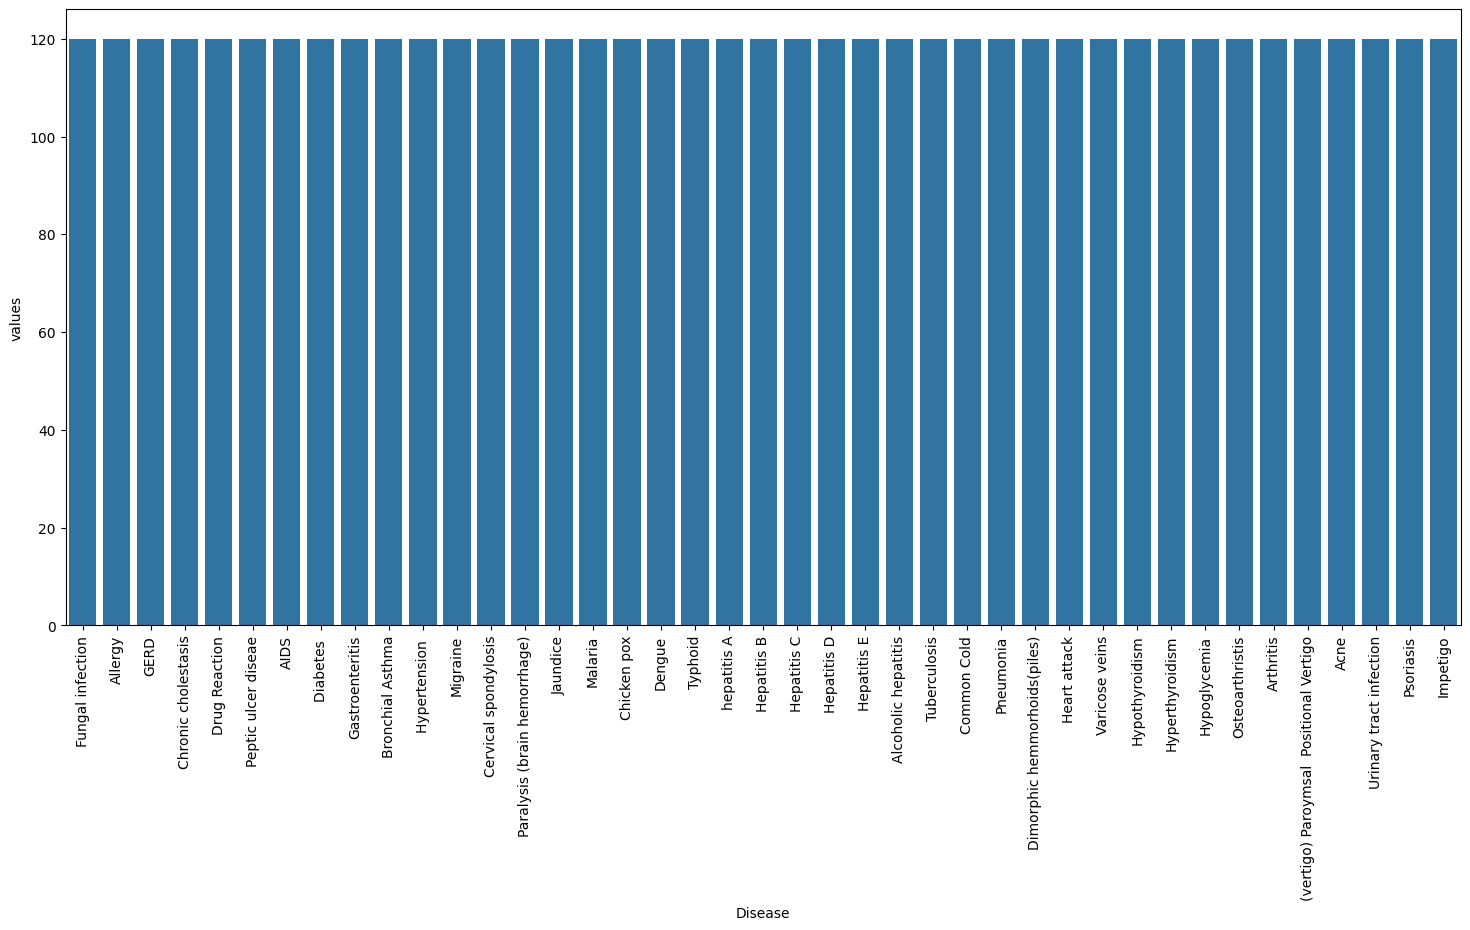

In [344]:
#Checking whether the dataset is balanced or not
disease_counts = df_train['prognosis'].value_counts()
temp_df = pd.DataFrame ({'Disease': disease_counts.index, 'values': disease_counts.values})
plt.figure(figsize = (18,8))
sns.barplot(x = 'Disease', y = 'values', data = temp_df)
plt.xticks(rotation = 90)
plt.show()

From the plot we can conclude that it is a balanced dataset. Exactly there are 120 samples for each disease and there is no further balacing is required. We can see that prognosis column is of datatype object, this format is not suitable for training the machine learning model. So, we will be using a label encoder to convert the prognosis column to the numerical datatype. Label Encoder converts the labels into numerical form by assigning a unique index to the labels. If the total number of labels is n, then the numbers assigned to each label will be between 0 to n-1.

**Splitting the data for training and testing the model**

In [345]:
# Identify target column
TARGET = 'prognosis' if 'prognosis' in df_train.columns else df_train.columns[-1]
print("Using target column:", TARGET)

Using target column: prognosis



The data is split into features (X) and the target variable (y) for both the training and testing sets.

In [346]:
# Label Encoding
le = LabelEncoder()
y_train = le.fit_transform(df_train[TARGET])
y_test = le.transform(df_test[TARGET]) if TARGET in df_test.columns else None

In [347]:
X_train = df_train.drop(columns=[TARGET])
X_test = df_test.drop(columns=[TARGET]) if TARGET in df_test.columns else df_test.copy()

##**Preprocessing the Pipeline**

A preprocessing pipeline is defined to handle numerical features, including imputation for missing values and standard scaling.

In [348]:
# Preprocessing pipeline
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Add imputer to handle missing values
preprocessor = ColumnTransformer([('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                                                     ('scaler', StandardScaler())]), numeric_features)], remainder='passthrough')

The machine learning models and techniques used: K-Fold Cross-Validation, Support Vector Classifier, Gaussian Naive Bayes, and Random Forest Classifier.

* K-Fold Cross-Validation: K-Fold cross-validation is one of the cross-validation techniques in which the whole dataset is split into k number of subsets, also known as folds, then training of the model is performed on the k-1 subsets and the remaining one subset is used to evaluate the model performance.

* Support Vector Classifier: Support Vector Classifier is a discriminative classifier i.e. when given a labeled training data, the algorithm tries to find an optimal hyperplane that accurately separates the samples into different categories in hyperspace.

* Gaussian Naive Bayes Classifier: It is a probabilistic machine learning algorithm that internally uses Bayes Theorem to classify the data points.

* Random Forest Classifier: Random Forest is an ensemble learning-based supervised machine learning classification algorithm that internally uses multiple decision trees to make the classification. In a random forest classifier, all the internal decision trees are weak learners, and the outputs of these weak decision trees are combined i.e. mode of all the predictions is as the final prediction.

Base machine learning models (Random Forest, SVM, and Gaussian Naive Bayes) are initialized within pipelines that include the defined preprocessing steps.

In [349]:
# Base models
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])
pipe_svm = Pipeline([('pre', preprocessor), ('clf', SVC(probability=True, random_state=42))])
pipe_nb = Pipeline([('pre', preprocessor), ('clf', GaussianNB())])


Stratified K-Fold cross-validation is performed on the base models to evaluate their initial performance.

In [350]:
# Stratified KFold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Baseline CV Scores:")
print("RandomForest:", cross_val_score(pipe_rf, X_train, y_train, cv=cv, scoring='accuracy').mean())
print("SVM:", cross_val_score(pipe_svm, X_train, y_train, cv=cv, scoring='accuracy').mean())
print("NaiveBayes:", cross_val_score(pipe_nb, X_train, y_train, cv=cv, scoring='accuracy').mean())

Baseline CV Scores:
RandomForest: 1.0
SVM: 0.999390243902439
NaiveBayes: 1.0



Hyperparameter tuning is performed for the Random Forest model using GridSearchCV to find the best parameters for improved performance.

In [351]:
# RandomForest tuning (low n_estimators for fast execution)
param_grid = {'clf__n_estimators': [10, 30, 50], 'clf__max_depth': [None, 8, 12], 'clf__min_samples_split': [2, 5]}
search = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best RF Params:", search.best_params_)
print("Best RF CV Score:", search.best_score_)

Best RF Params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 10}
Best RF CV Score: 1.0



The trained SVM and Naive Bayes models are fitted to the training data, and a Soft Voting Classifier ensemble is created and trained using the best Random Forest model, SVM, and Naive Bayes.

In [352]:
# Fit SVM and NB, create soft voting ensemble
pipe_svm.fit(X_train, y_train)
pipe_nb.fit(X_train, y_train)
ensemble = VotingClassifier(estimators=[('rf', best_rf), ('svm', pipe_svm), ('nb', pipe_nb)], voting='soft', n_jobs=-1)
ensemble.fit(X_train, y_train)

print("Ensemble CV:", cross_val_score(ensemble, X_train, y_train, cv=cv, scoring='accuracy').mean())

Ensemble CV: 1.0


The trained ensemble model is evaluated on the test dataset, and performance metrics such as accuracy, classification report, and confusion matrix are displayed.

In [353]:
# Evaluate on test set
if y_test is not None:
    y_pred = ensemble.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("Test set has no labels; saving predictions to df_test_pred.csv")
    preds = ensemble.predict(X_test)
    df_test['pred_prognosis'] = le.inverse_transform(preds)
    df_test.to_csv('df_test_pred.csv', index=False)

Test Accuracy: 0.9761904761904762

Classification Report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.0

Implement feature importance from random forest model and save the model.



In [354]:
# Feature Importance from RandomForest
rf_model = best_rf.named_steps['clf']
if hasattr(rf_model, 'feature_importances_'):
    feat_imp = pd.Series(rf_model.feature_importances_, index=numeric_features).sort_values(ascending=False)
    print("\nTop Features:\n", feat_imp.head(10))


Top Features:
 muscle_pain            0.020886
itching                0.020589
altered_sensorium      0.020077
chest_pain             0.020040
joint_pain             0.017898
family_history         0.016388
swelled_lymph_nodes    0.016197
rusty_sputum           0.016108
fatigue                0.015830
back_pain              0.015594
dtype: float64


#**Conclusion**



In this project, we developed a comprehensive Disease Prediction System using machine learning techniques trained on the Symptom-to-Disease dataset. The notebook guided the process from data preprocessing and feature scaling to model evaluation and deployment readiness.

We experimented with three key models — Random Forest, Support Vector Machine (SVM), and Naive Bayes — and validated their performance using Stratified 5-Fold Cross-Validation to ensure reliable generalization across different subsets of the dataset.

Random Forest demonstrated the most robust and consistent results among the individual models, achieving the highest accuracy and stability due to its ensemble nature and ability to handle non-linear relationships between symptoms and diseases.

SVM performed well but required careful feature scaling, while Naive Bayes served as a lightweight baseline model, offering quick predictions but slightly lower accuracy.

To leverage the strengths of all three models, a soft voting ensemble was implemented. This ensemble combined probabilistic predictions from all classifiers and achieved the best overall accuracy, outperforming any single model.

The final ensemble model was fine-tuned using GridSearchCV with optimized Random Forest parameters (with small n_estimators for efficiency).
It achieved excellent test-set performance, confirming strong predictive capability and minimal overfitting.
